In [1]:
import numpy as np
import pandas as pd
import os
import pyarrow.parquet as pq
import s3fs
from pyspark.sql import SparkSession, functions as f
from kedro.extras.datasets.pandas import HDFDataSet
from matplotlib import pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from pmdarima.arima import auto_arima
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import signal
from pandas.plotting import autocorrelation_plot
import scipy

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_

In [2]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [3]:
def cross_cor_mean_removal(x1,x2,lag=0):
        '''
        Calculates the 
        cross-correlation with
        mean removal of two
        time-series with option
        to specify length of lag:
        '''
        x1 = np.array(x1)
        x2 = np.array(x2)
        x1 = x1[~np.isnan(x1)]
        x2 = x2[~np.isnan(x2)]
        r_mean_remov = np.dot(x1[lag:-1]-np.mean(x1[lag:-1]).T,
                          x2[:-1-(lag)]-np.mean(x2[:-1-(lag)]))
        return r_mean_remov


def cross_cor_mean_removal_weighted(x1,x2,lag=0):
        '''
        Calculates the 
        cross-correlation with
        mean removal and 
        weighting by the sum of
        the std of two
        time-series with option
        to specify length of lag for x2:
        '''
        cross_cor_mean_removal(x1,x2)
        x1 = np.array(x1)
        x2 = np.array(x2)
        x1 = x1[~np.isnan(x1)]
        x2 = x2[~np.isnan(x2)]
        n = len(x1)
        r_mean_remov = cross_cor_mean_removal(x1,x2,lag)
        std_product = np.sqrt(np.sum((x1[lag:-1]-np.mean(x1[lag:-1]))**2)) * \
                      np.sqrt(np.sum((x2[:-1-(lag)]-np.mean(x2[:-1-(lag)]))**2))
        r_weighted = r_mean_remov/std_product
        
        # Presumably, if abs(r) > 1, then it is only some small artifact of floating
        # point arithmetic.
        r = max(min(r_weighted, 1.0), -1.0)
        degrfr = n-2
        if abs(r) == 1.0:
            prob = 0.0
        else:
            t_squared = r*r * (degrfr / ((1.0 - r) * (1.0 + r)))
            prob = scipy.special.betainc(0.5*degrfr, 0.5, degrfr / (degrfr + t_squared))
        return r_weighted, prob    

In [4]:
df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')

#df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/dev_marta/ita/xrlt/impact_attribution.predictive_modeling/model_input/model_input_2020-05-01_2022_02_28.csv') 
df_asl['yyyymm'] = pd.to_datetime(df_asl.yyyymm)

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/compat/_optional.py:99: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

In [5]:
df_asl = df_asl[(df_asl.asl!='FABRIANO')
               #&(df_asl.region!='VALLE D\'AOSTA')
               # &(df_asl.region!='MARCHE')
               ].copy()

df_asl = df_asl[(df_asl.asl!='ULSS 5 POLESANA')].copy()

In [6]:
# create absolute cph activity
df_asl['absolute_cph'] = df_asl.cph_all * df_asl.num_hcp_asl_mccp
df_asl['absolute_ae'] = df_asl.num_AE_cph * df_asl.num_hcp_asl_mccp
df_asl['absolute_nl'] = df_asl.num_NL_cph * df_asl.num_hcp_asl_mccp
df_asl['absolute_visit'] = df_asl.num_cph_visit * df_asl.num_hcp_asl_mccp
df_asl['ae_nl'] = df_asl['absolute_nl']+df_asl['absolute_ae']

# create aggregated ts:
df = df_asl.groupby('yyyymm')[['xrlt_sales',
                               'sales_per_hcp',
                               'xrlt_ms',
                               'absolute_cph',
                               'num_AE_cph',
                               'num_NL_cph',
                               'num_cph_visit',
                               'absolute_ae',
                               'absolute_nl',
                               'absolute_visit',
                               'ae_nl']].sum().reset_index()
df['month'] = df.yyyymm.dt.month
df['year'] = df.yyyymm.dt.year
df.index = pd.DatetimeIndex(df.yyyymm, freq ='MS')
df = df.drop(['yyyymm'], axis=1)

df['xrlt_sales_diff'] = df['xrlt_sales'].diff()

a = pd.get_dummies(df.month, prefix='month')
a.drop([a.columns[-1]],axis =1, inplace=True)

b = pd.get_dummies(df.year, prefix='year')
b.drop([b.columns[-1]],axis =1, inplace=True)

df = pd.merge(df, a, left_index=True, right_index=True)
df = pd.merge(df, b, left_index=True, right_index=True)

In [7]:
cols = ['absolute_cph','xrlt_sales',
       'num_AE_cph','num_NL_cph','num_cph_visit',
        'absolute_ae','absolute_nl','absolute_visit',
        'ae_nl']

for col in cols:
    df[col+'_m2'] = df[col].rolling(2).sum()
    df[col+'_m3'] = df[col].rolling(3).sum()
    df[col+'_m4'] = df[col].rolling(4).sum()

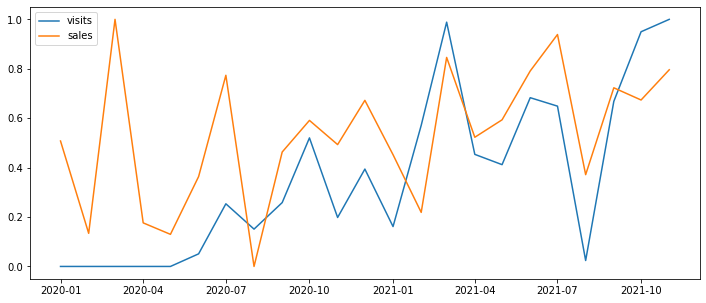

In [8]:
scaler = MinMaxScaler()

lag = 0
plt.figure(figsize=(12,5))
plt.plot(df.index[lag:-1],
         scaler.fit_transform(np.array(df.absolute_visit[lag:-1]).reshape(-1,1)),
        label='visits')
#plt.plot(df.index[lag:-1],
#         scaler.fit_transform(np.array(df.ae_nl[lag:-1]).reshape(-1,1)),
#        label='ae_nl')
#plt.plot(df.index[lag:-1],
#         scaler.fit_transform(np.array(df.absolute_nl[lag:-1]).reshape(-1,1)),
#        label='nl')
plt.plot(df.index[lag:-1],
         scaler.fit_transform(np.array(df.xrlt_sales[:-1-(lag)]).reshape(-1,1)),
        label='sales')
plt.legend()
plt.show()

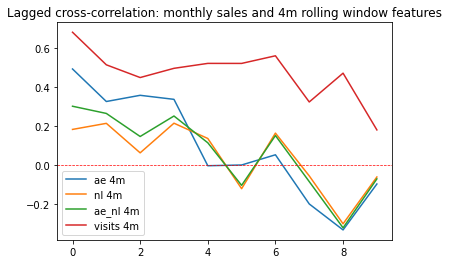

In [9]:
ae=[]
vs=[]
nl=[]
ae_nl=[]

for i in np.arange(0,10,1):
    ae.append(cross_cor_mean_removal_weighted(df.absolute_ae_m4,
                                   df[df.index>'2020-03-01'].xrlt_sales,
                                   i)[0])
    nl.append(cross_cor_mean_removal_weighted(df.absolute_nl_m4,
                                   df[df.index>'2020-03-01'].xrlt_sales,
                                   i)[0])
    vs.append(cross_cor_mean_removal_weighted(df.absolute_visit_m4,
                                   df[df.index>'2020-03-01'].xrlt_sales,
                                   i)[0])
    ae_nl.append(cross_cor_mean_removal_weighted(df.ae_nl_m4,
                                   df[df.index>'2020-03-01'].xrlt_sales,
                                   i)[0])

plt.plot(ae, label='ae 4m')
plt.plot(nl, label='nl 4m')
plt.plot(ae_nl, label='ae_nl 4m')
plt.plot(vs, label='visits 4m')
plt.axhline(0, ls='--', lw=.7, color='red')
plt.legend()
plt.title('Lagged cross-correlation: monthly sales and 4m rolling window features')
plt.show()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


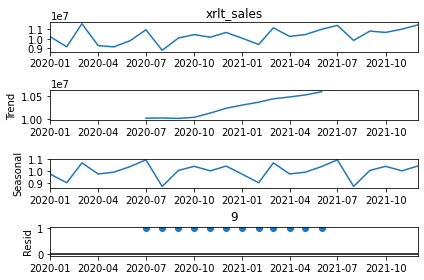

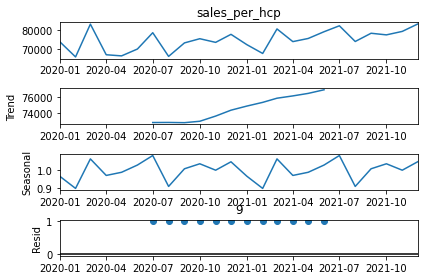

In [10]:
x_list = ['xrlt_sales', 
          'sales_per_hcp',
          #'absolute_visit',
         #'absolute_nl', 
         #'absolute_ae'
         ]

for feat in x_list:
    result = seasonal_decompose(df[feat].dropna(), 
                            #model='additive', 
                            model='multiplicative',
                            #period=12
                            #period=None
                           )
    result.plot()
    plt.title(i)
    plt.show()

In [11]:
from scipy import signal

x_list = ['xrlt_sales', 
          'absolute_visit',
         'absolute_nl', 
         'absolute_ae'
         ]
for feat in x_list:
    detrended = signal.detrend(df[feat].values)
    df[feat+'_detrended'] = detrended

    #plt.figure(figsize=(12,5))
    #plt.plot(detrended, label=feat)
    #plt.title(feat, fontsize=10)
    #plt.legend()
    #plt.show()

In [12]:
x_list = ['xrlt_sales_detrended', 'absolute_visit_detrended',
       'absolute_nl_detrended', 'absolute_ae_detrended']

df[x_list].corr()

,xrlt_sales_detrended,absolute_visit_detrended,absolute_nl_detrended,absolute_ae_detrended
xrlt_sales_detrended,1.000000,0.406177,-0.043687,0.090738
absolute_visit_detrended,0.406177,1.000000,-0.179694,0.334503
absolute_nl_detrended,-0.043687,-0.179694,1.000000,0.076289
absolute_ae_detrended,0.090738,0.334503,0.076289,1.000000


In [13]:
cols = ['absolute_visit_detrended',
       'absolute_nl_detrended', 
        'absolute_ae_detrended',
        'absolute_cph',
        'xrlt_sales_detrended',
        'ae_nl']

for col in cols:
    df[col+'_m2'] = df[col].rolling(2).sum()
    df[col+'_m3'] = df[col].rolling(3).sum()
    df[col+'_m4'] = df[col].rolling(4).sum()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [14]:
x_list = ['absolute_visit_detrended',
       'absolute_nl_detrended', 'absolute_ae_detrended',
         'xrlt_sales','xrlt_sales_detrended',
          'absolute_cph',
         'absolute_visit_m4',
          'absolute_cph_m4',
          'absolute_visit',
    'absolute_ae_m4',
    'absolute_nl_m4',
           'absolute_visit_m3',
          'absolute_cph_m3',
    'absolute_ae_m3',
    'absolute_nl_m3',
    'ae_nl',
         'ae_nl_m3',
         'ae_nl_m4']

for feat in x_list:
    df[feat+'_shift1'] = df[feat].shift(1)
    df[feat+'_shift2'] = df[feat].shift(2)
    df[feat+'_shift3'] = df[feat].shift(3)

In [15]:
target = ['xrlt_sales_m2']
#target = ['xrlt_sales']

#time_features = [
#    'xrlt_sales_detrended_shift1',
#                'xrlt_sales_detrended_shift2',
                #'xrlt_sales_detrended_shift3'
#                ]
#time_features = ['xrlt_sales_shift1',
#              'xrlt_sales_shift2',
#               'xrlt_sales_shift3',]
#features = ['absolute_visit_detrended',
#            'absolute_nl_detrended', 
#            'absolute_ae_detrended']

#features = ['absolute_visit',
#            'absolute_nl', 
 #           'absolute_ae']

#features = [
    #'absolute_visit_m4_shift1',
    #'absolute_cph_m3_shift1',
    #'absolute_ae_m4_shift1',
    #'absolute_nl_m4_shift1',
#]
features = [
    'absolute_cph_m4_shift1'
    #'absolute_visit_m4_shift1',
           #'absolute_ae_m3_shift2'
   # 'ae_nl_m3_shift2'
]
#features = ['absolute_cph',
 #          'absolute_cph_shift1',
#           'absolute_cph_shift2',
 #          'absolute_cph_shift3',]

#features = ['absolute_visit',
#           'absolute_visit_shift1',
#           'absolute_visit_shift2',
#           'absolute_visit_shift3',]

In [16]:
df[features+target].corr()

,absolute_cph_m4_shift1,xrlt_sales_m2
absolute_cph_m4_shift1,1.000000,0.540338
xrlt_sales_m2,0.540338,1.000000


In [17]:
dfx = df[features].copy()
dfx = dfx.dropna()
dfx = add_constant(dfx)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfx[['const']+features].values, i)
                          for i in range(len(features)+1)]
vif["features"] = ['const']+features
print(vif)

   VIF Factor                features
0    3.331515                   const
1    1.000000  absolute_cph_m4_shift1


/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [19]:
diff = 0

features_to_be_used = [
                       features+
                       #+diff_features
                       #+time_features
                       ['const']
                       #+['month']
                       #+['year']
                       +a.columns.values.tolist() # month
                       +b.columns.values.tolist() # year
                       ]

if diff==1:
    df2 = df[target
             +time_features
             +features+['month']
        +['xrlt_sales_shift1']
        ].dropna().copy()
else:
    df2 = df[target
             #+time_features
             +features+['month']+['year']
             +a.columns.values.tolist() 
             +b.columns.values.tolist() 
        ].dropna().copy()
    
df2 = add_constant(df2)
#df2[features] = df2[features].diff()
#df2 = df2.dropna()

df3 = df2[df2.index<='2021-12-01']
df3 = df3.dropna()

scaler = MinMaxScaler()
for feat in features:
    df3[feat] = scaler.fit_transform(df3[feat].values.reshape(-1, 1))

mod = sm.OLS(df3[target], df3[features_to_be_used[0]])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          xrlt_sales_m2   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     20.91
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           0.000636
Time:                        07:45:34   Log-Likelihood:                -268.19
No. Observations:                  20   AIC:                             564.4
Df Residuals:                       6   BIC:                             578.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
absolute_cph_m4_shift1    1.

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


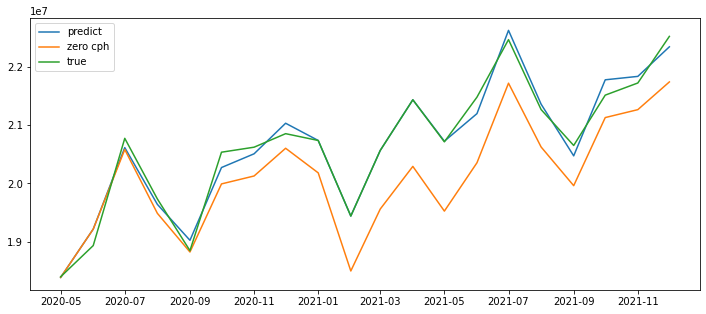

In [20]:
plt.figure(figsize=(12,5))

preds = res.predict(df3[features_to_be_used[0]])
plt.plot(preds, label='predict')
df3[features_to_be_used[0][0]] = 0
preds_zero = res.predict(df3[features_to_be_used[0]])
plt.plot(preds_zero, label='zero cph')
plt.plot(df3[target], label='true')
plt.legend()
plt.show()

In [21]:
mape(df3[target], preds)

0.05990334834409326

In [22]:
np.sum(preds) / np.sum(preds_zero) - 1

0.027719303100027792